# find_phone problem

The goal of this project is to find the center of a phone in an image. This notebook isn't meant to be run all at once. Step through each cell to see what it does, as some are there to restart processes such as downloading the inital images and duplicating the dataset, both of which take some time to run.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *

Specifying which gpu to trian on

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.set_device(0)
print(f'Using GPU#{torch.cuda.current_device()}')

Using GPU#0


## Data Cleaning

In [154]:
path = Path('data/phones'); path

PosixPath('data/phones')

After labeling our images on [dataturks](https://dataturks.com/) we get a downloaded .json file with a bunch of data regarding our labels and images. For this project, we really just need to isolate the image file names and the x/y coordinates for the points.

In [27]:
df = pd.read_json(f'{path}/phones.json', lines=True)
df.head()

,annotation,content,extras,metadata
0,"[{'label': ['phone'], 'shape': 'point', 'point...",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN,"{'first_done_at': 1548202608000, 'last_updated..."
1,"[{'label': ['phone'], 'shape': 'polygon', 'poi...",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN,"{'first_done_at': 1548356777000, 'last_updated..."
2,"[{'label': ['phone'], 'shape': 'polygon', 'poi...",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN,"{'first_done_at': 1548356929000, 'last_updated..."
3,"[{'label': ['phone'], 'shape': 'polygon', 'poi...",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN,"{'first_done_at': 1548356711000, 'last_updated..."
4,"[{'label': ['phone'], 'shape': 'polygon', 'poi...",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN,"{'first_done_at': 1548357106000, 'last_updated..."


In [28]:
train_df = pd.DataFrame(columns=['file_name', 'x', 'y'])
train_df.head()

,file_name,x,y


Downloading images and image labels from Dataturk and putting them into a pandas dataframe:

In [29]:
# RESTART
os.system(f'rm {path}/*.jpg')

256

In [30]:
%time

i = 0
while i < df['annotation'].count():
    coord = str(df['annotation'][i])
    coord = coord.split(", '")
    
    #Setting coordinate values
    coord = coord[2].split(', ')
    x = float(coord[0][11:])
    y = float(coord[1][:len(coord[1])-2])
    
    #Downloading images
    link = df['content'][i]
    os.system(f'wget -O {path}/{i}.jpg {link}')
    file_name = f'{i}.jpg'
    
    #Adding each image to train_df
    temp_data = {'file_name': file_name, 'x': x, 'y': y}
    temp_df = pd.DataFrame(data=temp_data, index=[-1])
    train_df = train_df.append(temp_df)
    
    i+=1

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 5.25 µs


In [31]:
train_df.set_index('file_name', inplace=True)
train_df.head()

,x,y
file_name,,
0.jpg,0.518354,0.470356
1.jpg,0.445244,0.500000
2.jpg,0.468425,0.517045
3.jpg,0.548361,0.772727
4.jpg,0.569145,0.697443


In [114]:
train_df.to_csv(path/'labels.csv')

### Training on a bigger dataset

We can dramatically increase the size of our dataset simply by multiplying the images we already have 'X' times. The order of operations will be:

- Copy and split original images into training and validation sets
- Multiply each image in training and validation folders by 'X' times
- Create a new dataframe to store the copied & original images in for labeling

In [32]:
# Setting a new path for our increased dataset
os.makedirs(f'{path}/large', exist_ok=True)
lrg_path = Path(f'{path}/large'); path

PosixPath('data/phones')

#### Copying Images

In [101]:
# Restart
os.system(f'rm -rf {lrg_path}')
os.makedirs(lrg_path, exist_ok=True)
os.system(f'cp {path}/*.jpg {lrg_path}')

0

In [102]:
amt = os.listdir(lrg_path)
np.array(amt)

array(['112.jpg', '54.jpg', '83.jpg', '101.jpg', ..., '93.jpg', '38.jpg', '87.jpg', '14.jpg'], dtype='<U7')

Manually split train & valid datasets

In [103]:
def train_valid_split(path, pct):
    os.system(f'mkdir {path}/train')
    os.system(f'mkdir {path}/valid')
    
    amt = os.listdir(path)
    
    i=0
    while i < (len(amt)*pct): 
        if amt[i][-3:]=='jpg':
            os.system(f'mv {path}/{amt[i]} {lrg_path}/valid')
        i+=1
    
    for x in amt:
        if x[-3:]=='jpg':
            os.system(f'mv {path}/{x} {lrg_path}/train/') 

In [104]:
train_valid_split(lrg_path, 0.2)

In [105]:
amt_train = os.listdir(f'{lrg_path}/train')
amt_valid = os.listdir(f'{lrg_path}/valid')

Copying Images

In [107]:
datasets = {'train':amt_train, 'valid':amt_valid}

len(datasets['train'])

for ds in datasets:
    
    amt = datasets[ds]
    amt_len = len(amt)
    mult_amt = 10
    i = 1

    while i < mult_amt:
        n = 0
        while n < amt_len:
            amt.append(amt[n][:-4] + '_copy_' + str(i) + '.jpg')
            os.system(f'cp {lrg_path}/{ds}/{amt[n]} {lrg_path}/{ds}/{amt[n][:-4]}_copy_{str(i)}.jpg')
            n+=1
        i+=1

#### Copying Point Coords

In [116]:
# RESTART
os.system(f'rm {lrg_path}/large_labels.csv')
os.system(f'cp {path}/labels.csv {lrg_path}/large_labels.csv')

0

In [120]:
large_df = pd.read_csv(f'{lrg_path}/large_labels.csv')
large_df.set_index('file_name', inplace=True)
large_df.head()

,x,y
file_name,,
0.jpg,0.518354,0.470356
1.jpg,0.445244,0.500000
2.jpg,0.468425,0.517045
3.jpg,0.548361,0.772727
4.jpg,0.569145,0.697443


In [121]:
# Re-run this again after copying images
amt_train = os.listdir(f'{lrg_path}/train')
amt_valid = os.listdir(f'{lrg_path}/valid')

In [124]:
i = 0
prefix = '.'
amt = amt_valid # Run for each train & valid dataset once

while i < len(amt):
    if (len(amt[i]) > 7) and (amt[i][0]!=prefix):
        temp_df = pd.DataFrame({'x':[0], 'y':[0]}, index=[amt[i]])

        x_val = large_df.loc[f'{amt[i][:-11]}.jpg']['x']
        y_val = large_df.loc[f'{amt[i][:-11]}.jpg']['y']

        temp_df['x'] = x_val
        temp_df['y'] = y_val

        large_df = large_df.append(temp_df)
            
    i+=1

In [158]:
len(large_df)

1140

Saving csv to use for later:

In [126]:
large_df.to_csv(lrg_path/'large_df.csv')

### Image Points Labeling Function

We need some way to put points in our dataframe onto actual images, so this function does exactly that. When using the datablock api, we'll need this function to tell the model where all the points are.

(None, torch.Size([2610, 4640]))

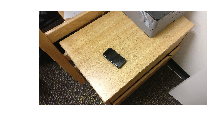

In [129]:
file_name = large_df.index.values[1]
img = open_image(path/file_name)
img.show(), img.size

In [130]:
df = large_df # Specify which df to use

def get_ctr(fname):
    fname = str(fname) # Convert path object to string
    fname = fname.split(sep='/')
    fname = fname[len(fname) - 1]
    
    x = df.loc[fname]['x']
    y = df.loc[fname]['y']
    
#     print(img.size)
#     img = open_image(path/'train'/fname)
    scaled_x = x*img.size[1]
    scaled_y = y*img.size[0]
    
    return tensor([scaled_y, scaled_x]) #Needs to be in (y,x) configuration and be a tensor

In [131]:
get_ctr(file_name)

tensor([1305.0000, 2065.9312])

In [132]:
# Returns points cooresponding to each image
def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [133]:
ctr = get_ctr(file_name)

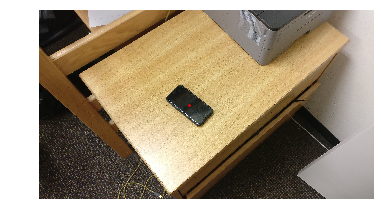

In [134]:
img.show(y=get_ip(img, ctr), figsize=(6, 6))

### Image Points Collate Function

Some transforms will move the phone out of the image, so we need a way to tell the model that the center point of the phone isn't in the image. In this case, we just remove the "bad" image out of the training/validation set. In the future, it would probably be better and help accuracy if we had a way to keep the images in the dataset instead of just removing them completely.

In [135]:
def ip_pad_collate(samples:BatchSamples):
    samples = to_data(samples)
    final_samples = samples.copy()
    
    count = 1 
    while count < len(samples):
        for i, sample in enumerate(samples):
            if (sample[1].shape[0] == 0): 
                del samples[i]
        count+=1
            
    return tensor([s[0].numpy() for s in samples]), tensor([s[1].numpy() for s in samples])

### Setting up Datablock

Here we are defining all of our transforms. Because of our small dataset of ~115 images, we'll want a lot of data augmentation to increase model accuracy. See [this page](https://docs.fast.ai/vision.transform.html) on what each of these transforms does to the image. 

In [136]:
max_rotate = 10.0
max_zoom = 1.1
max_warp = 0.2
max_lighting = 0.2
p_affine = 0.75
p_lighting = 0.75
   
res = [rand_crop()]

res.append(dihedral_affine(p=p_affine))
res.append(symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine))
res.append(rotate(degrees=(-max_rotate,max_rotate), p=p_affine))
res.append(rand_zoom(scale=(1.,max_zoom), p=p_affine))
res.append(flip_affine(p=p_affine))
res.append(squish(p=p_affine))
res.append(brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting))
res.append(contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting))
   
tfms = (res, [crop_pad()])

The below code uses Fastai's [Datablock API](https://docs.fast.ai/data_block.html#Step-2:-Split-the-data-between-the-training-and-the-validation-set) which essentially does all the work to turn our raw dataset into a format ready to be fed into DL modlels. To learn more about the Datablock API and what it does, check out [this article](https://blog.usejournal.com/finding-data-block-nirvana-a-journey-through-the-fastai-data-block-api-c38210537fe4).

In [137]:
%%time
data = (PointsItemList.from_folder(path)
        .random_split_by_pct() #change to split_by_folder() or random_split_by_pct()
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch(bs=32, collate_fn=ip_pad_collate).normalize(imagenet_stats)
       )

CPU times: user 29.5 s, sys: 2.23 s, total: 31.7 s
Wall time: 10.3 s


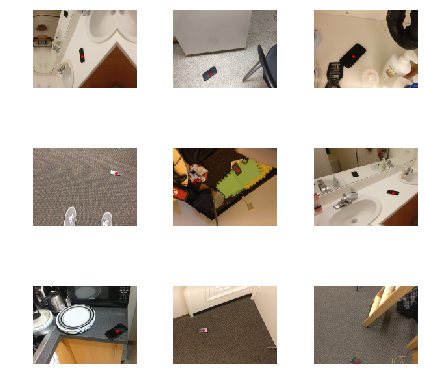

In [152]:
data.show_batch(3, figsize=(6,6), ds_type=DatasetType.Train)

## Training

In [139]:
# Clear memory
learn = None; gc.collect()

13808

In [140]:
callbacks = [ShowGraph, BnFreeze]
learn = create_cnn(data, models.resnet34, wd=0.2, callback_fns=callbacks)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


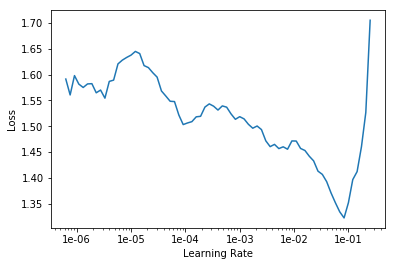

In [141]:
learn.lr_find()
learn.recorder.plot()

In [142]:
lr = 4e-2

epoch,train_loss,valid_loss
1,1.438768,0.744631
2,1.042261,0.414071
3,0.713421,0.253782
4,0.498447,0.198436
5,0.374346,0.213439
6,0.313769,0.219132
7,0.288360,0.222585
8,0.280295,0.208306
9,0.266538,0.203851
10,0.251466,0.212503


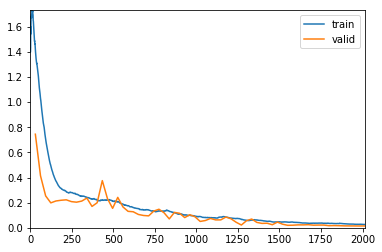

In [143]:
learn.fit_one_cycle(65, slice(lr))

In [144]:
learn.save('stage-1')

In [145]:
learn.load('stage-1'); # The semicolon doesn't print out the whole model

In [146]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


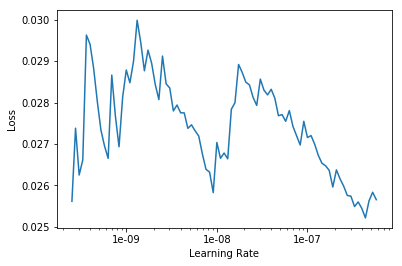

In [148]:
learn.lr_find(start_lr=1e-10, end_lr=1e-6)
learn.recorder.plot()

epoch,train_loss,valid_loss
1,0.031253,0.014767
2,0.031836,0.014681
3,0.030420,0.015549
4,0.031254,0.015998
5,0.031700,0.014923
6,0.030263,0.015347
7,0.030291,0.015232
8,0.029870,0.014244
9,0.029666,0.014653
10,0.029867,0.014840


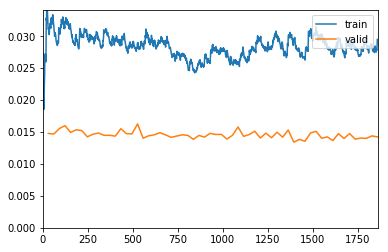

In [149]:
learn.fit_one_cycle(60, slice(5e-8,3e-7))

One issue I'm trying to work out is how after unfreeszing my model, my training and validation loss doesn't improve at all. Regardless, the results of the project are pretty good.

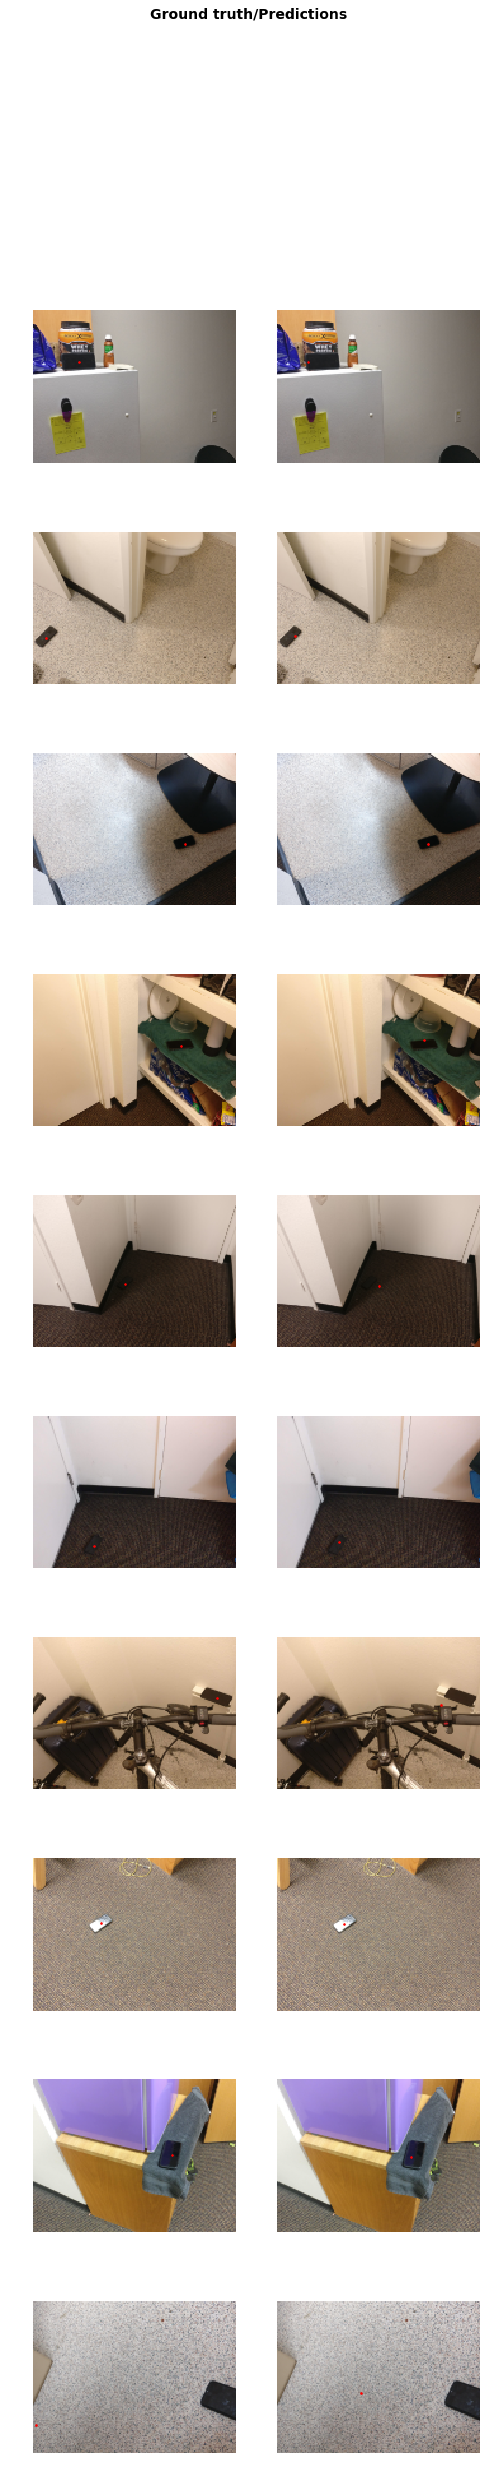

In [150]:
learn.show_results(rows=10)

In [151]:
learn.save('stage-2')

In [ ]:
learn.load('stage-2');

In [ ]:
learn.export()

## Playground

In [ ]:
preds, targs = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
preds[0], targs[0]

In [ ]:
data.valid_ds[3][0]

In [ ]:
targs[3][0], preds[3]

In [ ]:
output_img = 

np_preds = preds[output_img].numpy()
np_targs = targs[output_img][0].numpy()

pred_x = 0.5 + np_preds[1]*0.5
pred_y = 0.5 + np_preds[0]*0.5

targ_x = 0.5 + np_targs[1]*0.5
targ_y = 0.5 + np_targs[0]*0.5

In [ ]:
#Normalized Coordinates from 0,1
print(f'Targs = x:{round(targ_x, 4)} y:{round(targ_y, 4)}')
print(f'Preds = x:{round(pred_x, 4)} y:{round(pred_y, 4)}')
data.valid_ds[output_img][0]